In [272]:
import pandas as pd
import numpy as np
import os
from fbprophet import Prophet
from fbprophet.make_holidays import make_holidays_df
import joblib
from tqdm import tqdm_notebook as tqdm
# import datetime class from datetime module
from datetime import datetime
import pandas as pd

In [273]:
# Data reading and pre processing
# data_df = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/PepsiCo POC/","Forecasting/Prophet_PepsiCo/Tran_Month_v5","Belgium_Liquid_Zero_Filled.csv"))
#Data = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Final Data/","Zero_Filled_Data_NBTY_1502_Month.csv"))
Data = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Final Data/","Brand_Smooth_Data_NBTY.csv"))

#Data = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/Data/","Shipments/","ShipmentsData_Brand.csv"))
#Data = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Shipments/","Shipments_CategoryData.csv"))
#Data = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Shipments/","Category_Shipments_Data_v1.csv"))


#Data = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Data/","Shipments_Data_Item.csv"))

# Data['month'] = Data['Time.[Planning Month]'].str.slice(0, 3)
# Data['year'] = Data['Time.[Planning Month]'].str.slice(4, 6)
# Data['tempDate'] = '01'+Data['month'].astype(str)+'20'+''+Data['year'].astype(str)
# Data['Date'] = pd.to_datetime(Data['tempDate'], format='%d%b%Y')

# # Column renaming
# Data.rename(columns = {'Version.[Version Name]':'Version','Item.[Stat Level]':'ts_id'}, inplace = True)
Data['Date'] = pd.to_datetime(Data['Date'], format='%Y-%m-%d')
Data.rename(columns = {'SKU':'ts_id'}, inplace = True)
Data

,ts_id,Date,Sales
0,BB - BALANCE BAR,2018-01-01,14002.41
1,BF - BODY FORTRESS,2018-01-01,27542.67
2,Brand_Not_Given,2018-01-01,2461.44
3,DO - DOCTOR ORGANICS,2018-01-01,1595.04
4,DS - DISNEY BRAND,2018-01-01,7385.05
...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.89
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.28
824,SO - SUNDOWN ORGANICS,2021-01-01,940.56
825,SU - SOLGAR USNUTRITION,2021-01-01,0.00


In [274]:
Data
#Data.columns

,ts_id,Date,Sales
0,BB - BALANCE BAR,2018-01-01,14002.41
1,BF - BODY FORTRESS,2018-01-01,27542.67
2,Brand_Not_Given,2018-01-01,2461.44
3,DO - DOCTOR ORGANICS,2018-01-01,1595.04
4,DS - DISNEY BRAND,2018-01-01,7385.05
...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.89
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.28
824,SO - SUNDOWN ORGANICS,2021-01-01,940.56
825,SU - SOLGAR USNUTRITION,2021-01-01,0.00


## Holiday Calendars

# Important Prophet Links



In [6]:
# https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
# https://facebook.github.io/prophet/docs/trend_changepoints.html
# https://github.com/Diyago/ML-DL-scripts/blob/master/time%20series%20regression/anomaly%20detection/anomaly-detection-using-facebook-s-prophet.ipynb
# https://peerj.com/preprints/3190/

In [7]:
# mode = 'multiplicative'
# uniq_comb = data_df[['ts_id']].drop_duplicates()
# time_col = 'Date'
# y_col = 'Sales'

In [8]:
#Here from tenant data
# data_df = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Final Data/","Actual_l1Data - Copy.csv"))
# time_col = 'Week'
# y_col = 'QTY'
# data_df['ts_id'] = data_df['ts_id'].astype(str)
# data_df['Week'] = pd.to_datetime(data_df['Week'], format='%d-%m-%Y')
# data_df

In [9]:
# prediction_dftemp = data_df[data_df.ts_id==100004102]
# prediction_dftemp
# data_dfb = data_df
# uniq_comb = data_df[['ts_id']].drop_duplicates()

In [10]:
## to see holiday calendars
NBTY_Holiday = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Forecasting/","Fact.Holidays.csv"))

NBTY_Holiday = NBTY_Holiday.rename(columns={"Time.Day": "ds",
                                        "Holiday Type":"holiday"})
NBTY_Holiday['ds'] = pd.to_datetime(NBTY_Holiday.ds, format='%d-%b-%y')

NBTY_Holiday = NBTY_Holiday[["ds","holiday"]]

NBTY_Holiday.reset_index(drop=True)

,ds,holiday
0,2015-01-01,New Year
1,2015-01-19,Martin Luther King Jr.
2,2015-05-25,Memorial Day
3,2015-07-04,Independence Day
4,2015-09-07,Labor Day
...,...,...
63,2020-11-11,Veterans Day
64,2020-11-26,Thanksgiving
65,2020-11-27,Day After Thanksgiving
66,2020-12-24,Christmas Eve


# Outlier Correction

In [11]:
def fit_predict_model(dataframe,NBTY_Holiday, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(interval_width = interval_width,
                changepoint_range = changepoint_range, holidays=NBTY_Holiday)
    m = m.fit(dataframe, iter = 100)   
    forecast = m.predict(dataframe)
    forecast = forecast.merge(dataframe[['ds','y']], on=['ds'], how='left')
    forecast['fact'] = forecast['y']
    return forecast

In [12]:
data_df = Data.copy()
data_df

,ts_id,Date,Sales
0,BB - BALANCE BAR,2018-01-01,14002.408422
1,BF - BODY FORTRESS,2018-01-01,27542.668265
2,Brand_Not_Given,2018-01-01,2461.440000
3,DO - DOCTOR ORGANICS,2018-01-01,1595.039725
4,DS - DISNEY BRAND,2018-01-01,7385.050834
...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.889043
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.277551
824,SO - SUNDOWN ORGANICS,2021-01-01,940.563584
825,SU - SOLGAR USNUTRITION,2021-01-01,0.000000


In [11]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    #print(forecasted)
    return forecasted

In [12]:
result_list = []

In [13]:
time_col = 'Date'
y_col = 'Sales'
uniq_comb = data_df[['ts_id']].drop_duplicates()
for idx, row in tqdm(uniq_comb.iterrows(), total = len(uniq_comb)):
    ts_id = row['ts_id']
    #ts_id = '100000133'
    try:
        subset_df = data_df[(data_df.ts_id == ts_id)]
        subset_df = subset_df[[time_col,y_col]].rename({time_col:'ds',y_col:'y'},axis=1)
        subset_df['ds'] = pd.to_datetime(subset_df['ds'])
        pred = fit_predict_model(subset_df, NBTY_Holiday)
        pred['ts_id'] = ts_id
        # Detect anomaly here itself
        pred1 = pred[(pred.ts_id == ts_id)]
        pred2 = detect_anomalies(pred1)
        pred2['ts_id'] = ts_id
        result_list.append(pred2)
        #print(pred)
        #print(result_list)
    except Exception as e:
        print ("Skipped {} because of {}".format(ts_id, e))
#result_list.append(pred)

<ipython-input-13-60cf122b6c81>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, row in tqdm(uniq_comb.iterrows(), total = len(uniq_comb)):


  0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [709]:
prediction_df = pd.concat(result_list, sort=False).dropna()
prediction_df['OutlierCorrected'] = np.where(prediction_df['anomaly'] == 0, prediction_df['fact'], prediction_df['yhat'])
prediction_df['OutlierCorrected'] = np.where((prediction_df['fact'] < prediction_df['yhat']), prediction_df['fact'], prediction_df['OutlierCorrected'])
prediction_df['OutlierCorrected'] = np.where((prediction_df['OutlierCorrected'] < 0), 0 , prediction_df['OutlierCorrected'])

prediction_df.columns

Index(['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact', 'anomaly',
       'importance', 'ts_id', 'OutlierCorrected'],
      dtype='object')

In [710]:
prediction_df.to_csv('NBTY_Outlier_Detected&Corrected_Brand_v11_1803.csv')

In [711]:
data_df = prediction_df[["ts_id","ds","OutlierCorrected"]] # storing to data_df dataframe and feature engineering on it.
data_df.rename(columns = {'ds':'Date'}, inplace = True)


# Feature Engineering

In [13]:
# data_df = Data.copy()
data_df

,ts_id,Date,Sales
0,BB - BALANCE BAR,2018-01-01,14002.408422
1,BF - BODY FORTRESS,2018-01-01,27542.668265
2,Brand_Not_Given,2018-01-01,2461.440000
3,DO - DOCTOR ORGANICS,2018-01-01,1595.039725
4,DS - DISNEY BRAND,2018-01-01,7385.050834
...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.889043
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.277551
824,SO - SUNDOWN ORGANICS,2021-01-01,940.563584
825,SU - SOLGAR USNUTRITION,2021-01-01,0.000000


In [14]:
# def encode(data, col, max_val):
#     data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
#     data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
#     data[col + '_fourier'] = data[col + '_cos'] + data[col + '_sin']
#     return data

# # Convert this feature to its sin and cos components to represent cyclical behavior
# for n in ('Month', 'quarter'):
#     #print("Adding cyclic features for ", n)
#     max_val = max(merged_df_final.loc[:, n])
#     data_df = encode(data_df, n , max_val)


In [15]:
def time_features(df):
    #Date = time_col
    df['Year_Nominal'] = df['Date'].dt.year
    df['Year_Num'] = df['Year_Nominal'] - df['Year_Nominal'].min() + 1
    # df['Year_Nominal'] = df['Year_Nominal'].astype(str)
    
    df['Quarter_Num'] = df['Date'].dt.quarter
    df['Quarter_Sin'] = np.sin(2 * np.pi * (df['Quarter_Num']-1)/4)
    df['Quarter_Cos'] = np.cos(2 * np.pi * (df['Quarter_Num']-1)/4)
    # df['Quarter_Nominal'] = df['Quarter_Num'].astype(str)
    
    df['Month_Num'] = df['Date'].dt.month
    df['Month_Sin'] = np.sin(2 * np.pi * (df['Month_Num']-1)/12)
    df['Month_Cos'] = np.cos(2 * np.pi * (df['Month_Num']-1)/12)
    # df['Month_Nominal'] = df['Month_Num'].astype(str)
    
    return df




In [16]:
def create_lag_variables(df, date_column, grouped_on, shifting_var
                         , month_ascending=True, lag_vars_range = list()):
    """
    Function to create lag-variables    
    Parameters
    ----------
    df : pandas dataframe
        DESCRIPTION. Containing column names like month, banner_id, sku_id and actual_quantity.
    lag_vars_range : list, not optional
        DESCRIPTION. Pass a set of integers which will then generate the individual
        lag variables.

    Returns
    -------
    df : updated pandas dataframe with lag variables
        The passed dataframe is updated with the set of lag-variables 
        as passed to lag_vars_range

    """
    for lag in lag_vars_range:
        df['lag_'+str(lag)] = (df
                               .sort_values(by = date_column, ascending = month_ascending)
                               .groupby(grouped_on)[shifting_var].shift(lag)
                               .fillna(0))
    return df

In [17]:
def create_lead_variables(df, date_column, grouped_on, shifting_var
                         , month_ascending=True, lag_vars_range = list()):
    """
    Function to create lag-variables    
    Parameters
    ----------
    df : pandas dataframe
        DESCRIPTION. Containing column names like month, banner_id, sku_id and actual_quantity.
    lag_vars_range : list, not optional
        DESCRIPTION. Pass a set of integers which will then generate the individual
        lag variables.

    Returns
    -------
    df : updated pandas dataframe with lag variables
        The passed dataframe is updated with the set of lag-variables 
        as passed to lag_vars_range

    """
    for lag in lag_vars_range:
        df['lag_'+str(lag)] = (df
                               .sort_values(by = date_column, ascending = month_ascending)
                               .groupby(grouped_on)[shifting_var].shift(-lag)
                               .fillna(0))
    return df

In [18]:
#data_df = create_lag_variables(data_df,date_column="Date",grouped_on="ts_id",shifting_var="Sales",month_ascending=True,lag_vars_range=[1,2,3])

In [19]:
# Checking lags created properly or not..
# prediction_dftemp = data_df[data_df.ts_id=='BB - BALANCE BAR']
# prediction_dftemp

In [20]:
def create_moving_avg(df, ma_vars = list()):
    """
    

    Parameters
    ----------
    df : TYPE
        DESCRIPTION.
    ma_vars : TYPE, optional
        DESCRIPTION. The default is list().

    Returns
    -------
    None.

    """
    
    
    # for ma_var in ma_vars:
    #     for i in range(ma_var):
    #         numerator = df["lag_"+(i+3)]
    #         df["ma_"+str(ma_var)] = df["lag_"+(i+3)]
    
    
    for ma_var in ma_vars:
        if ma_var == 1:
            df["naive"] = df["lag_3"]
        if ma_var == 2:
            df["ma_2"] = (df["lag_3"]+df["lag_4"])/2
        if ma_var == 3:
            df["ma_3"] = (df["lag_3"]+df["lag_4"]+df["lag_5"])/3
        if ma_var == 4:
            df["ma_4"] = (df["lag_3"]+df["lag_4"]+df["lag_5"]+df["lag_6"])/4
        if ma_var == 5:
            df["ma_5"] = (df["lag_3"]+df["lag_4"]+df["lag_5"]+df["lag_6"]+df["lag_7"])/5
            
    return df


In [21]:
def get_season(x):
    if x >= 12 and x <= 2:
        return "Winter"
    elif x >= 3 and x <= 5:
        return "Spring"
    elif x >= 6 and x <= 8:
        return "Summer"
    else:
        return "Autumn"

def add_time_features(df, time_col):
    df["month_1"] = df[time_col].dt.month
    #df["quarter"] = df[time_col].dt.quarter    
    df["season"] = df["month_1"].apply(get_season)
    df.drop(["month_1"], axis = 1, inplace = True)
    return df


In [22]:
data_df = time_features(data_df)
#data_df = add_time_features(data_df,time_col='Date')
data_df

,ts_id,Date,Sales,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,Month_Cos
0,BB - BALANCE BAR,2018-01-01,14002.408422,2018,1,1,0.0,1.0,1,0.0,1.0
1,BF - BODY FORTRESS,2018-01-01,27542.668265,2018,1,1,0.0,1.0,1,0.0,1.0
2,Brand_Not_Given,2018-01-01,2461.440000,2018,1,1,0.0,1.0,1,0.0,1.0
3,DO - DOCTOR ORGANICS,2018-01-01,1595.039725,2018,1,1,0.0,1.0,1,0.0,1.0
4,DS - DISNEY BRAND,2018-01-01,7385.050834,2018,1,1,0.0,1.0,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.889043,2021,4,1,0.0,1.0,1,0.0,1.0
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.277551,2021,4,1,0.0,1.0,1,0.0,1.0
824,SO - SUNDOWN ORGANICS,2021-01-01,940.563584,2021,4,1,0.0,1.0,1,0.0,1.0
825,SU - SOLGAR USNUTRITION,2021-01-01,0.000000,2021,4,1,0.0,1.0,1,0.0,1.0


In [23]:
data_df = add_time_features(data_df,time_col="Date")
data_df

,ts_id,Date,Sales,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,Month_Cos,season
0,BB - BALANCE BAR,2018-01-01,14002.408422,2018,1,1,0.0,1.0,1,0.0,1.0,Autumn
1,BF - BODY FORTRESS,2018-01-01,27542.668265,2018,1,1,0.0,1.0,1,0.0,1.0,Autumn
2,Brand_Not_Given,2018-01-01,2461.440000,2018,1,1,0.0,1.0,1,0.0,1.0,Autumn
3,DO - DOCTOR ORGANICS,2018-01-01,1595.039725,2018,1,1,0.0,1.0,1,0.0,1.0,Autumn
4,DS - DISNEY BRAND,2018-01-01,7385.050834,2018,1,1,0.0,1.0,1,0.0,1.0,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.889043,2021,4,1,0.0,1.0,1,0.0,1.0,Autumn
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.277551,2021,4,1,0.0,1.0,1,0.0,1.0,Autumn
824,SO - SUNDOWN ORGANICS,2021-01-01,940.563584,2021,4,1,0.0,1.0,1,0.0,1.0,Autumn
825,SU - SOLGAR USNUTRITION,2021-01-01,0.000000,2021,4,1,0.0,1.0,1,0.0,1.0,Autumn


In [24]:
data_df['Is_Autumn'] = np.where(data_df['season']=='Autumn',1,0)
data_df['Is_Winter'] = np.where(data_df['season']=='Winter',1,0)
data_df['Is_Summer'] = np.where(data_df['season']=='Summer',1,0)
data_df['Is_Spring'] = np.where(data_df['season']=='Spring',1,0)

In [25]:
data_df
#data_df.describe()

,ts_id,Date,Sales,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,Month_Cos,season,Is_Autumn,Is_Winter,Is_Summer,Is_Spring
0,BB - BALANCE BAR,2018-01-01,14002.408422,2018,1,1,0.0,1.0,1,0.0,1.0,Autumn,1,0,0,0
1,BF - BODY FORTRESS,2018-01-01,27542.668265,2018,1,1,0.0,1.0,1,0.0,1.0,Autumn,1,0,0,0
2,Brand_Not_Given,2018-01-01,2461.440000,2018,1,1,0.0,1.0,1,0.0,1.0,Autumn,1,0,0,0
3,DO - DOCTOR ORGANICS,2018-01-01,1595.039725,2018,1,1,0.0,1.0,1,0.0,1.0,Autumn,1,0,0,0
4,DS - DISNEY BRAND,2018-01-01,7385.050834,2018,1,1,0.0,1.0,1,0.0,1.0,Autumn,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.889043,2021,4,1,0.0,1.0,1,0.0,1.0,Autumn,1,0,0,0
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.277551,2021,4,1,0.0,1.0,1,0.0,1.0,Autumn,1,0,0,0
824,SO - SUNDOWN ORGANICS,2021-01-01,940.563584,2021,4,1,0.0,1.0,1,0.0,1.0,Autumn,1,0,0,0
825,SU - SOLGAR USNUTRITION,2021-01-01,0.000000,2021,4,1,0.0,1.0,1,0.0,1.0,Autumn,1,0,0,0


## Temperature Data

In [26]:
Temperature = pd.read_excel(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Data/","Weather_Data_1702.xlsx"), sheet_name = 'Fact Data(1)')
Temperature = Temperature.groupby('Month').agg({'Avg Temp. (C)':'mean','Precipitation (mm)':'sum'}).reset_index()
Temperature = Temperature.rename(columns={"Month": "Date"})
Temperature

,Date,Avg Temp. (C),Precipitation (mm)
0,2016-01-01,0.529212,247396.5
1,2016-02-01,3.737976,247593.6
2,2016-03-01,6.456546,330986.6
3,2016-04-01,9.995482,311791.1
4,2016-05-01,13.300982,343254.0
...,...,...,...
56,2020-09-01,17.194008,293802.6
57,2020-10-01,11.347671,287112.6
58,2020-11-01,5.731924,259583.9
59,2020-12-01,1.510651,242885.0


## Holiday Feature Engineering

In [27]:
NBTY_Holiday = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Data/","IsHolidayMonthLevel.csv"))

NBTY_Holiday = NBTY_Holiday.rename(columns={"Time.[Planning Month]": "Date","IsHoliday" : "HolidayCount"})
NBTY_Holiday['Date'] = pd.to_datetime(NBTY_Holiday.Date, format='%b-%y')

NBTY_Holiday = NBTY_Holiday[["Date","HolidayCount","IsPrimeMonth"]]
NBTY_Holiday.reset_index(drop=True)
#NBTY_Holiday.columns
NBTY_Holiday

,Date,HolidayCount,IsPrimeMonth
0,2015-01-01,2,0
1,2015-05-01,1,0
2,2015-07-01,1,1
3,2015-09-01,1,0
4,2015-11-01,3,0
5,2015-12-01,2,0
6,2016-01-01,2,0
7,2016-05-01,1,0
8,2016-07-01,2,1
9,2016-09-01,1,0


## Holiday Feature Engineering

In [28]:
#NBTY_Holiday = NBTY_Holidaycreate_lag_variables(train, date_column = 'Date', grouped_on = 'ts_id', shifting_var = 'OutlierCorrected', month_ascending=True, lag_vars_range = [1,2,3,4,5])
#train = create_lag_variables(train, date_column = 'Date', grouped_on = 'ts_id', shifting_var = 'OutlierCorrected', month_ascending=True, lag_vars_range = [1,2,3,4,5])


## Final Dataframe after adding Holiday and Weather Information

In [29]:
merged_df1 = pd.merge(data_df,NBTY_Holiday, how = 'left', on = 'Date')
merged_df1 = create_lag_variables(merged_df1, date_column = 'Date', grouped_on = 'ts_id', shifting_var = 'HolidayCount', month_ascending=True, lag_vars_range = [1,2,3])
merged_df1 = merged_df1.rename(columns={"lag_1": "HolidayCount_Lag1","lag_2" : "HolidayCount_Lag2", "lag_3" :"HolidayCount_Lag3"})
merged_df1 = create_lag_variables(merged_df1, date_column = 'Date', grouped_on = 'ts_id', shifting_var = 'IsPrimeMonth', month_ascending=True, lag_vars_range = [1,2,3])
merged_df1 = merged_df1.rename(columns={"lag_1": "IsPrimeMonth_Lag1","lag_2" : "IsPrimeMonth_Lag2", "lag_3" :"IsPrimeMonth_Lag3"})
merged_df1


# Leading Vars
merged_df1 = pd.merge(data_df,NBTY_Holiday, how = 'left', on = 'Date')
merged_df1 = create_lead_variables(merged_df1, date_column = 'Date', grouped_on = 'ts_id', shifting_var = 'HolidayCount', month_ascending=True, lag_vars_range = [1,2,3])
merged_df1 = merged_df1.rename(columns={"lag_1": "HolidayCount_Lead1","lag_2" : "HolidayCount_Lead2", "lag_3" :"HolidayCount_Lead3"})
merged_df1 = create_lead_variables(merged_df1, date_column = 'Date', grouped_on = 'ts_id', shifting_var = 'IsPrimeMonth', month_ascending=True, lag_vars_range = [1,2,3])
merged_df1 = merged_df1.rename(columns={"lag_1": "IsPrimeMonth_Lead1","lag_2" : "IsPrimeMonth_Lead2", "lag_3" :"IsPrimeMonth_Lead3"})
merged_df1

,ts_id,Date,Sales,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,...,Is_Summer,Is_Spring,HolidayCount,IsPrimeMonth,HolidayCount_Lead1,HolidayCount_Lead2,HolidayCount_Lead3,IsPrimeMonth_Lead1,IsPrimeMonth_Lead2,IsPrimeMonth_Lead3
0,BB - BALANCE BAR,2018-01-01,14002.408422,2018,1,1,0.0,1.0,1,0.0,...,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BF - BODY FORTRESS,2018-01-01,27542.668265,2018,1,1,0.0,1.0,1,0.0,...,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Brand_Not_Given,2018-01-01,2461.440000,2018,1,1,0.0,1.0,1,0.0,...,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DO - DOCTOR ORGANICS,2018-01-01,1595.039725,2018,1,1,0.0,1.0,1,0.0,...,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DS - DISNEY BRAND,2018-01-01,7385.050834,2018,1,1,0.0,1.0,1,0.0,...,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.889043,2021,4,1,0.0,1.0,1,0.0,...,0,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.277551,2021,4,1,0.0,1.0,1,0.0,...,0,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
824,SO - SUNDOWN ORGANICS,2021-01-01,940.563584,2021,4,1,0.0,1.0,1,0.0,...,0,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
825,SU - SOLGAR USNUTRITION,2021-01-01,0.000000,2021,4,1,0.0,1.0,1,0.0,...,0,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
merged_df1 = pd.merge(merged_df1,Temperature, how = 'left', on = 'Date')
merged_df1

,ts_id,Date,Sales,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,...,HolidayCount,IsPrimeMonth,HolidayCount_Lead1,HolidayCount_Lead2,HolidayCount_Lead3,IsPrimeMonth_Lead1,IsPrimeMonth_Lead2,IsPrimeMonth_Lead3,Avg Temp. (C),Precipitation (mm)
0,BB - BALANCE BAR,2018-01-01,14002.408422,2018,1,1,0.0,1.0,1,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7
1,BF - BODY FORTRESS,2018-01-01,27542.668265,2018,1,1,0.0,1.0,1,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7
2,Brand_Not_Given,2018-01-01,2461.440000,2018,1,1,0.0,1.0,1,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7
3,DO - DOCTOR ORGANICS,2018-01-01,1595.039725,2018,1,1,0.0,1.0,1,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7
4,DS - DISNEY BRAND,2018-01-01,7385.050834,2018,1,1,0.0,1.0,1,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.889043,2021,4,1,0.0,1.0,1,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.277551,2021,4,1,0.0,1.0,1,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8
824,SO - SUNDOWN ORGANICS,2021-01-01,940.563584,2021,4,1,0.0,1.0,1,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8
825,SU - SOLGAR USNUTRITION,2021-01-01,0.000000,2021,4,1,0.0,1.0,1,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8


## Price Data

In [31]:
Price = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Data/","Fact.PriceData.csv"))

Price = Price.rename(columns={"Time.[Month]": "Date","Item.[L3]": "ts_id"})
Price['Date'] = pd.to_datetime(Price.Date, format='%b-%y')

# Price = NBTY_Holiday[["Date","HolidayCount","IsPrimeMonth"]]
# Price.reset_index(drop=True)
# #NBTY_Holiday.columns
Price

,Version.[Version Name],Date,ts_id,Price
0,CurrentWorkingView,2017-04-01,SU - SOLGAR USNUTRITION,468.19
1,CurrentWorkingView,2017-11-01,SU - SOLGAR USNUTRITION,2027.07
2,CurrentWorkingView,2018-04-01,SU - SOLGAR USNUTRITION,1270.99
3,CurrentWorkingView,2018-06-01,SU - SOLGAR USNUTRITION,3126.08
4,CurrentWorkingView,2018-07-01,SU - SOLGAR USNUTRITION,2453.07
...,...,...,...,...
851,CurrentWorkingView,2019-08-01,MC - MAC & MAYA,211.68
852,CurrentWorkingView,2020-10-01,MC - MAC & MAYA,9.99
853,CurrentWorkingView,2019-09-01,MC - MAC & MAYA,39.69
854,CurrentWorkingView,2019-12-01,MC - MAC & MAYA,83.16


In [32]:
merged_df1 = pd.merge(merged_df1,Price[['ts_id','Date','Price']], how = 'left', on = ['ts_id','Date'])
merged_df1

,ts_id,Date,Sales,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,...,IsPrimeMonth,HolidayCount_Lead1,HolidayCount_Lead2,HolidayCount_Lead3,IsPrimeMonth_Lead1,IsPrimeMonth_Lead2,IsPrimeMonth_Lead3,Avg Temp. (C),Precipitation (mm),Price
0,BB - BALANCE BAR,2018-01-01,14002.408422,2018,1,1,0.0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7,190.80
1,BF - BODY FORTRESS,2018-01-01,27542.668265,2018,1,1,0.0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7,805.90
2,Brand_Not_Given,2018-01-01,2461.440000,2018,1,1,0.0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7,NaN
3,DO - DOCTOR ORGANICS,2018-01-01,1595.039725,2018,1,1,0.0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7,668.95
4,DS - DISNEY BRAND,2018-01-01,7385.050834,2018,1,1,0.0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7,157.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.889043,2021,4,1,0.0,1.0,1,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8,698.06
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.277551,2021,4,1,0.0,1.0,1,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8,357.13
824,SO - SUNDOWN ORGANICS,2021-01-01,940.563584,2021,4,1,0.0,1.0,1,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8,517.00
825,SU - SOLGAR USNUTRITION,2021-01-01,0.000000,2021,4,1,0.0,1.0,1,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8,NaN


## Sellout Forecast

In [33]:
merged_df1 = merged_df1.rename(columns={"Sales": "OutlierCorrected"})
merged_df1

,ts_id,Date,OutlierCorrected,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,...,IsPrimeMonth,HolidayCount_Lead1,HolidayCount_Lead2,HolidayCount_Lead3,IsPrimeMonth_Lead1,IsPrimeMonth_Lead2,IsPrimeMonth_Lead3,Avg Temp. (C),Precipitation (mm),Price
0,BB - BALANCE BAR,2018-01-01,14002.408422,2018,1,1,0.0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7,190.80
1,BF - BODY FORTRESS,2018-01-01,27542.668265,2018,1,1,0.0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7,805.90
2,Brand_Not_Given,2018-01-01,2461.440000,2018,1,1,0.0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7,NaN
3,DO - DOCTOR ORGANICS,2018-01-01,1595.039725,2018,1,1,0.0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7,668.95
4,DS - DISNEY BRAND,2018-01-01,7385.050834,2018,1,1,0.0,1.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244987,232722.7,157.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.889043,2021,4,1,0.0,1.0,1,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8,698.06
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.277551,2021,4,1,0.0,1.0,1,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8,357.13
824,SO - SUNDOWN ORGANICS,2021-01-01,940.563584,2021,4,1,0.0,1.0,1,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8,517.00
825,SU - SOLGAR USNUTRITION,2021-01-01,0.000000,2021,4,1,0.0,1.0,1,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.910199,95204.8,NaN


In [220]:
cut_off_date = '2020-07-01' # current month - 1, start from 4
CUTOFF_DATE = "2020-10-01" # Current Month
test_end_date = "2021-06-01"

In [221]:
Temperature = Temperature.rename(columns={"Month": "Date"})


In [222]:
from dateutil.relativedelta import *

In [223]:
SelloutForecast = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Data/Sellout Forecast/","SelloutForecast_Month_Aggregated.csv"))
SelloutForecastCM = SelloutForecast[SelloutForecast.GenerationMonthDate==CUTOFF_DATE]
SelloutForecastCM.to_csv("look1.csv")
#SelloutForecastCM = create_lag_variables(SelloutForecastCM,date_column = 'MonthDate1', grouped_on = '[Item].[Planning Item]', shifting_var = 'Sellout', month_ascending=True, lag_vars_range = [3])
Lag3 =  pd.to_datetime(CUTOFF_DATE) + relativedelta(months=+3)
Lag3
SelloutForecastCM['MonthDate1'] = pd.to_datetime(SelloutForecastCM['MonthDate1'])
SelloutForecastCM = SelloutForecastCM[SelloutForecastCM.MonthDate1==Lag3]
#SelloutForecastCM.to_csv("look.csv")

In [224]:
train = merged_df1[merged_df1.Date<CUTOFF_DATE]
#test = data_df[(data_df.Date>=CUTOFF_DATE)&(data_df.Date<=test_end_date)]
test = merged_df1[(merged_df1.Date>=CUTOFF_DATE)&(merged_df1.Date<=test_end_date)]
test

,ts_id,Date,OutlierCorrected,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,...,IsPrimeMonth,HolidayCount_Lead1,HolidayCount_Lead2,HolidayCount_Lead3,IsPrimeMonth_Lead1,IsPrimeMonth_Lead2,IsPrimeMonth_Lead3,Avg Temp. (C),Precipitation (mm),Price
731,BB - BALANCE BAR,2020-10-01,28993.10,2020,3,4,-1.00,-0.00,10,-1.00,...,1.00,3.00,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,2096.70
732,BE - BEST BAR EVER,2020-10-01,0.00,2020,3,4,-1.00,-0.00,10,-1.00,...,1.00,3.00,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,nan
733,BF - BODY FORTRESS,2020-10-01,56739.32,2020,3,4,-1.00,-0.00,10,-1.00,...,1.00,3.00,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,10927.90
734,Brand_Not_Given,2020-10-01,9954.31,2020,3,4,-1.00,-0.00,10,-1.00,...,1.00,3.00,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,nan
735,DO - DOCTOR ORGANICS,2020-10-01,471.38,2020,3,4,-1.00,-0.00,10,-1.00,...,1.00,3.00,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,217.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,SK - SUNDOWN KIDS,2021-01-01,2380.89,2021,4,1,0.00,1.00,1,0.00,...,nan,0.00,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,698.06
823,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.28,2021,4,1,0.00,1.00,1,0.00,...,nan,0.00,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,357.13
824,SO - SUNDOWN ORGANICS,2021-01-01,940.56,2021,4,1,0.00,1.00,1,0.00,...,nan,0.00,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,517.00
825,SU - SOLGAR USNUTRITION,2021-01-01,0.00,2021,4,1,0.00,1.00,1,0.00,...,nan,0.00,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,nan


## Additional Lag and Moving averages Features for only train data and snaive forecast for test data

In [225]:
   
train = create_lag_variables(train, date_column = 'Date', grouped_on = 'ts_id', shifting_var = 'OutlierCorrected', month_ascending=True, lag_vars_range = [1,2,3,4,5])
train = create_moving_avg(train, ma_vars = [1,2,3])

#train1=train.groupby(['ts_id'])['OutlierCorrected'].apply(lambda x: x.rolling(window=3).mean().shift(3))
#train1.to_frame()

## Conversion Percentage from Glance View

In [226]:
ConversionPercentage = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Data/","ConversionData.csv"))
#ConversionPercentage = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Data/","Category_ConversionData.csv"))

ConversionPercentage = ConversionPercentage.rename(columns={"Time.[Month]": "Date","Item.[L3]": "ts_id","Conversion% PW":"ConversionPercentage"})
#ConversionPercentage = ConversionPercentage.rename(columns={"Time.[Month]": "Date","Item.[A2]": "ts_id","Conversion% PW":"ConversionPercentage"})

ConversionPercentage['Date'] = pd.to_datetime(ConversionPercentage.Date, format='%b-%y')
ConversionPercentage

,Version.[Version Name],Date,ts_id,ConversionPercentage
0,CurrentWorkingView,2019-12-01,SU - SOLGAR USNUTRITION,0.14
1,CurrentWorkingView,2020-01-01,SU - SOLGAR USNUTRITION,0.17
2,CurrentWorkingView,2020-02-01,SU - SOLGAR USNUTRITION,0.09
3,CurrentWorkingView,2020-03-01,SU - SOLGAR USNUTRITION,0.10
4,CurrentWorkingView,2020-04-01,SU - SOLGAR USNUTRITION,0.17
...,...,...,...,...
279,CurrentWorkingView,2020-08-01,PP - PURITANS PRIDE,0.33
280,CurrentWorkingView,2020-09-01,PP - PURITANS PRIDE,0.46
281,CurrentWorkingView,2020-10-01,PP - PURITANS PRIDE,0.40
282,CurrentWorkingView,2019-12-01,PP - PURITANS PRIDE,0.73


In [227]:
train = pd.merge(train,ConversionPercentage[['ts_id','Date','ConversionPercentage']], how = 'left', on = ['ts_id','Date'])
train

,ts_id,Date,OutlierCorrected,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,...,Price,lag_1,lag_2,lag_3,lag_4,lag_5,naive,ma_2,ma_3,ConversionPercentage
0,BB - BALANCE BAR,2018-01-01,14002.41,2018,1,1,0.00,1.00,1,0.00,...,190.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan
1,BF - BODY FORTRESS,2018-01-01,27542.67,2018,1,1,0.00,1.00,1,0.00,...,805.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan
2,Brand_Not_Given,2018-01-01,2461.44,2018,1,1,0.00,1.00,1,0.00,...,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan
3,DO - DOCTOR ORGANICS,2018-01-01,1595.04,2018,1,1,0.00,1.00,1,0.00,...,668.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan
4,DS - DISNEY BRAND,2018-01-01,7385.05,2018,1,1,0.00,1.00,1,0.00,...,157.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,SK - SUNDOWN KIDS,2020-09-01,0.00,2020,3,3,0.00,-1.00,9,-0.87,...,nan,0.00,0.00,0.00,1968.52,1086.38,0.00,984.26,1018.30,0.16
727,SN - SUNDOWN NONEQUITY KIDS,2020-09-01,0.00,2020,3,3,0.00,-1.00,9,-0.87,...,nan,0.00,0.00,0.00,739.81,5222.36,0.00,369.90,1987.39,0.16
728,SO - SUNDOWN ORGANICS,2020-09-01,712.39,2020,3,3,0.00,-1.00,9,-0.87,...,517.00,551.55,741.07,1027.33,1603.80,1987.63,1027.33,1315.56,1539.59,0.60
729,SU - SOLGAR USNUTRITION,2020-09-01,0.00,2020,3,3,0.00,-1.00,9,-0.87,...,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11


## Glance View

In [228]:
GlanceView = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Data/","GlanceView_Data.csv"))
#ConversionPercentage = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Data/","Category_ConversionData.csv"))

GlanceView = GlanceView.rename(columns={"Time.[Month]": "Date","Item.[L3]": "ts_id","Glance View PW":"GlanceView"})
#ConversionPercentage = ConversionPercentage.rename(columns={"Time.[Month]": "Date","Item.[A2]": "ts_id","Conversion% PW":"ConversionPercentage"})

GlanceView['Date'] = pd.to_datetime(GlanceView.Date, format='%b-%y')
GlanceView

,Version.[Version Name],Date,ts_id,GlanceView
0,CurrentWorkingView,2019-12-01,SU - SOLGAR USNUTRITION,22.71
1,CurrentWorkingView,2020-01-01,SU - SOLGAR USNUTRITION,375.57
2,CurrentWorkingView,2020-02-01,SU - SOLGAR USNUTRITION,220.71
3,CurrentWorkingView,2020-03-01,SU - SOLGAR USNUTRITION,412.57
4,CurrentWorkingView,2020-04-01,SU - SOLGAR USNUTRITION,302.14
...,...,...,...,...
279,CurrentWorkingView,2020-08-01,PP - PURITANS PRIDE,1226.86
280,CurrentWorkingView,2020-09-01,PP - PURITANS PRIDE,1243.71
281,CurrentWorkingView,2020-10-01,PP - PURITANS PRIDE,128.57
282,CurrentWorkingView,2019-12-01,PP - PURITANS PRIDE,6.43


In [229]:
train = pd.merge(train,GlanceView[['ts_id','Date','GlanceView']], how = 'left', on = ['ts_id','Date'])


## Lag 3 Glance View

In [230]:
train = create_lag_variables(train, date_column = 'Date', grouped_on = 'ts_id', shifting_var = 'GlanceView', month_ascending=True, lag_vars_range = [3])

train = train.rename(columns={"lag_3": "GlanceView_Lag3"})
train

,ts_id,Date,OutlierCorrected,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,...,lag_1,lag_2,GlanceView_Lag3,lag_4,lag_5,naive,ma_2,ma_3,ConversionPercentage,GlanceView
0,BB - BALANCE BAR,2018-01-01,14002.41,2018,1,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan
1,BF - BODY FORTRESS,2018-01-01,27542.67,2018,1,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan
2,Brand_Not_Given,2018-01-01,2461.44,2018,1,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan
3,DO - DOCTOR ORGANICS,2018-01-01,1595.04,2018,1,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan
4,DS - DISNEY BRAND,2018-01-01,7385.05,2018,1,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,SK - SUNDOWN KIDS,2020-09-01,0.00,2020,3,3,0.00,-1.00,9,-0.87,...,0.00,0.00,2282.14,1968.52,1086.38,0.00,984.26,1018.30,0.16,10262.14
727,SN - SUNDOWN NONEQUITY KIDS,2020-09-01,0.00,2020,3,3,0.00,-1.00,9,-0.87,...,0.00,0.00,593.14,739.81,5222.36,0.00,369.90,1987.39,0.16,1970.57
728,SO - SUNDOWN ORGANICS,2020-09-01,712.39,2020,3,3,0.00,-1.00,9,-0.87,...,551.55,741.07,4121.00,1603.80,1987.63,1027.33,1315.56,1539.59,0.60,2691.43
729,SU - SOLGAR USNUTRITION,2020-09-01,0.00,2020,3,3,0.00,-1.00,9,-0.87,...,0.00,0.00,224.86,0.00,0.00,0.00,0.00,0.00,0.11,423.86


In [231]:
temp_train1 = train[train.Year_Nominal==2019]
temp_train1
test = pd.merge(test, temp_train1[['ts_id','Month_Num','GlanceView_Lag3']], how='left', on=['Month_Num','ts_id'])
test

,ts_id,Date,OutlierCorrected,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,...,HolidayCount_Lead1,HolidayCount_Lead2,HolidayCount_Lead3,IsPrimeMonth_Lead1,IsPrimeMonth_Lead2,IsPrimeMonth_Lead3,Avg Temp. (C),Precipitation (mm),Price,GlanceView_Lag3
0,BB - BALANCE BAR,2020-10-01,28993.10,2020,3,4,-1.00,-0.00,10,-1.00,...,3.00,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,2096.70,0.00
1,BE - BEST BAR EVER,2020-10-01,0.00,2020,3,4,-1.00,-0.00,10,-1.00,...,3.00,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,nan,0.00
2,BF - BODY FORTRESS,2020-10-01,56739.32,2020,3,4,-1.00,-0.00,10,-1.00,...,3.00,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,10927.90,0.00
3,Brand_Not_Given,2020-10-01,9954.31,2020,3,4,-1.00,-0.00,10,-1.00,...,3.00,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,nan,0.00
4,DO - DOCTOR ORGANICS,2020-10-01,471.38,2020,3,4,-1.00,-0.00,10,-1.00,...,3.00,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,217.78,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,SK - SUNDOWN KIDS,2021-01-01,2380.89,2021,4,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,698.06,0.00
92,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.28,2021,4,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,357.13,0.00
93,SO - SUNDOWN ORGANICS,2021-01-01,940.56,2021,4,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,517.00,nan
94,SU - SOLGAR USNUTRITION,2021-01-01,0.00,2021,4,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,nan,0.00


# Out of Stock

In [232]:
OOS = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Data/","OutOfStock.csv"))
#ConversionPercentage = pd.read_csv(os.path.join("C:/Users/kadambini.indurkar/NBTY/","Data/","Category_ConversionData.csv"))

OOS = OOS.rename(columns={"Time.[Month]": "Date","Item.[L3]": "ts_id","Rep OOS% PW":"OOS"})
#ConversionPercentage = ConversionPercentage.rename(columns={"Time.[Month]": "Date","Item.[A2]": "ts_id","Conversion% PW":"ConversionPercentage"})

OOS['Date'] = pd.to_datetime(OOS.Date, format='%b-%y')

train = pd.merge(train,OOS[['ts_id','Date','OOS']], how = 'left', on = ['ts_id','Date'])

train = create_lag_variables(train, date_column = 'Date', grouped_on = 'ts_id', shifting_var = 'OOS', month_ascending=True, lag_vars_range = [3])

train = train.rename(columns={"lag_3": "OOS_Lag3"})

temp_train11 = train[train.Year_Nominal==2019]
test = pd.merge(test, temp_train11[['ts_id','Month_Num','OOS_Lag3']], how='left', on=['Month_Num','ts_id'])
test.describe()


,OutlierCorrected,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,Month_Cos,Is_Autumn,...,HolidayCount_Lead2,HolidayCount_Lead3,IsPrimeMonth_Lead1,IsPrimeMonth_Lead2,IsPrimeMonth_Lead3,Avg Temp. (C),Precipitation (mm),Price,GlanceView_Lag3,OOS_Lag3
count,96.00,96.00,96.00,96.00,96.00,96.00,96.00,96.00,96.00,96.00,...,96.00,96.00,96.00,96.00,96.00,96.00,96.00,75.00,93.00,93.00
mean,73841.22,2020.25,3.25,3.25,-0.75,0.25,8.50,-0.59,0.59,1.00,...,0.50,0.00,0.00,0.00,0.00,5.13,221196.58,6411.85,0.00,0.00
std,180307.91,0.44,0.44,1.31,0.44,0.44,4.41,0.39,0.39,0.00,...,0.87,0.00,0.00,0.00,0.00,3.97,74826.66,9379.41,0.00,0.00
min,0.00,2020.00,3.00,1.00,-1.00,-0.00,1.00,-1.00,-0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,1.51,95204.80,6.74,0.00,0.00
25%,227.82,2020.00,3.00,3.25,-1.00,-0.00,7.75,-0.90,0.38,1.00,...,0.00,0.00,0.00,0.00,0.00,1.81,205964.95,156.88,0.00,0.00
50%,6855.15,2020.00,3.00,4.00,-1.00,-0.00,10.50,-0.68,0.68,1.00,...,0.00,0.00,0.00,0.00,0.00,3.82,251234.45,917.65,0.00,0.00
75%,55991.05,2020.25,3.25,4.00,-0.75,0.25,11.25,-0.38,0.90,1.00,...,0.50,0.00,0.00,0.00,0.00,7.14,266466.07,8796.84,0.00,0.00
max,888024.83,2021.00,4.00,4.00,0.00,1.00,12.00,0.00,1.00,1.00,...,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,39658.87,0.00,0.00


In [233]:
def perform_sktime_naive(train, test, date_col,dependent_var
                         , naive_strategy="seasonal_last"
                         , grouped_on = "ts_id" ):
    
    """
    Function-7: Seasonal Naive. In case of no seasonality, naive will be the result.
    """
    
    # Library import
    from sktime.forecasting.naive import NaiveForecaster
    
    
    af_forecast = pd.DataFrame()
    all_groups = train[grouped_on].unique()


    for group in tqdm(all_groups):
        y_train = train[train[grouped_on]==group].drop([grouped_on, date_col],axis=1)[dependent_var]
        test_group = test[test[grouped_on]==group]
        if len(y_train)==0:
            continue
        
        try:
            # Seasonal Naive Forecast
            forecaster = NaiveForecaster(strategy=naive_strategy, sp=11)
            forecaster.fit(y_train)
            y_pred = forecaster.predict(fh=forecast_length)
            test_group["sn_forecast"]=y_pred[-1:].values[0]
            test_group["sn_status"]=0
        except:
            # Naive Forecast
            forecaster = NaiveForecaster(strategy="last", sp=11)
            forecaster.fit(y_train)
            y_pred = forecaster.predict(fh=forecast_length)
            test_group["sn_forecast"]=y_pred[-1:].values[0]
            test_group["sn_status"]=1
            
        # Create predictions for the future, evaluate on test
        af_forecast = pd.concat([af_forecast, test_group], axis=0, ignore_index = True)
    
    return af_forecast

In [234]:
# test_lags_forecast = perform_sktime_naive(train, test, date_col = 'Date',dependent_var='lag_1',naive_strategy="seasonal_last"
#                          , grouped_on = "ts_id")

In [235]:
temp_train = train[train.Year_Nominal==2019]
temp_train
#test = pd.merge(test, temp_train[['ts_id','Month_Num','lag_1','lag_2','lag_3','lag_4','lag_5','naive','ma_2','ma_3']], how='left', on=['Month_Num','ts_id'])
test

,ts_id,Date,OutlierCorrected,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,...,HolidayCount_Lead2,HolidayCount_Lead3,IsPrimeMonth_Lead1,IsPrimeMonth_Lead2,IsPrimeMonth_Lead3,Avg Temp. (C),Precipitation (mm),Price,GlanceView_Lag3,OOS_Lag3
0,BB - BALANCE BAR,2020-10-01,28993.10,2020,3,4,-1.00,-0.00,10,-1.00,...,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,2096.70,0.00,0.00
1,BE - BEST BAR EVER,2020-10-01,0.00,2020,3,4,-1.00,-0.00,10,-1.00,...,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,nan,0.00,0.00
2,BF - BODY FORTRESS,2020-10-01,56739.32,2020,3,4,-1.00,-0.00,10,-1.00,...,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,10927.90,0.00,0.00
3,Brand_Not_Given,2020-10-01,9954.31,2020,3,4,-1.00,-0.00,10,-1.00,...,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,nan,0.00,0.00
4,DO - DOCTOR ORGANICS,2020-10-01,471.38,2020,3,4,-1.00,-0.00,10,-1.00,...,2.00,0.00,0.00,0.00,0.00,11.35,287112.60,217.78,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,SK - SUNDOWN KIDS,2021-01-01,2380.89,2021,4,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,698.06,0.00,0.00
92,SN - SUNDOWN NONEQUITY KIDS,2021-01-01,728.28,2021,4,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,357.13,0.00,0.00
93,SO - SUNDOWN ORGANICS,2021-01-01,940.56,2021,4,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,517.00,nan,nan
94,SU - SOLGAR USNUTRITION,2021-01-01,0.00,2021,4,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,1.91,95204.80,nan,0.00,0.00


In [236]:
# train1 = train[train.ts_id== 'BB - BALANCE BAR']
# train1.to_csv("tets.csv")

In [237]:
pred_periods = sorted(test.Date.astype(str).unique())
pred_periods

['2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01']

In [238]:
forecast_length = len(pred_periods)

<AxesSubplot:>

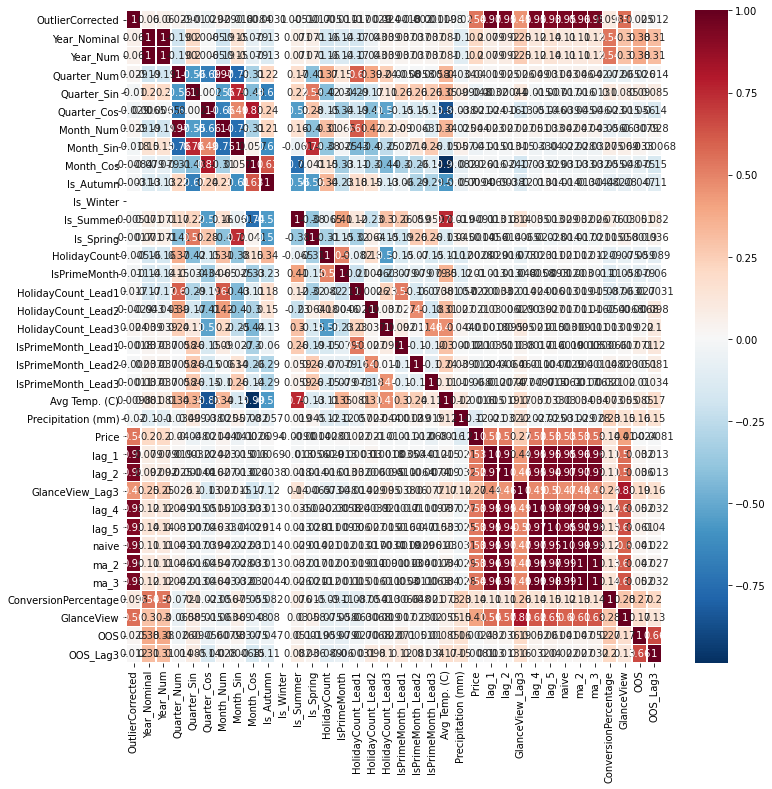

In [275]:
pearson = train.corr(method='pearson')
import seaborn as sb
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
sb.heatmap(pearson, 
            xticklabels=pearson.columns,
            yticklabels=pearson.columns,
            cmap='RdBu_r',
            annot=True,linewidths=0.5, ax=ax)

## Seasonal Index

In [240]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# # multiplicative seasonal component
# result_mul = seasonal_decompose(merged_df1['value'][-36:],   # 3 years
#                                 model='multiplicative', 
#                                 extrapolate_trend='freq')

# seasonal_index = result_mul.seasonal[-12:].to_frame()
# seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# # merge with the base data
# merged_df1['month'] = merged_df1.index.month
# df = pd.merge(merged_df1, seasonal_index, how='left', on='month')
# df.columns = ['value', 'month', 'seasonal_index']
# df.index = merged_df1.index  # reassign the index.

In [241]:

# data_df = merged_df1.copy()
# data_df.Date = pd.to_datetime(data_df.Date, yearfirst=True)
# data_df = data_df[data_df.Date<=cut_off_date]


## SARIMAX

In [242]:
import pmdarima as pm #Finally installed again after reinstalling it..
# from pyramid.arima import auto_arima



In [243]:
uniq_combs = train.ts_id.unique()
data_df.columns

Index(['ts_id', 'Date', 'Sales', 'Year_Nominal', 'Year_Num', 'Quarter_Num',
       'Quarter_Sin', 'Quarter_Cos', 'Month_Num', 'Month_Sin', 'Month_Cos',
       'season', 'Is_Autumn', 'Is_Winter', 'Is_Summer', 'Is_Spring'],
      dtype='object')

In [244]:
train = train.fillna(0)
test = test.fillna(0)
train.columns

Index(['ts_id', 'Date', 'OutlierCorrected', 'Year_Nominal', 'Year_Num',
       'Quarter_Num', 'Quarter_Sin', 'Quarter_Cos', 'Month_Num', 'Month_Sin',
       'Month_Cos', 'season', 'Is_Autumn', 'Is_Winter', 'Is_Summer',
       'Is_Spring', 'HolidayCount', 'IsPrimeMonth', 'HolidayCount_Lead1',
       'HolidayCount_Lead2', 'HolidayCount_Lead3', 'IsPrimeMonth_Lead1',
       'IsPrimeMonth_Lead2', 'IsPrimeMonth_Lead3', 'Avg Temp. (C)',
       'Precipitation (mm)', 'Price', 'lag_1', 'lag_2', 'GlanceView_Lag3',
       'lag_4', 'lag_5', 'naive', 'ma_2', 'ma_3', 'ConversionPercentage',
       'GlanceView', 'OOS', 'OOS_Lag3'],
      dtype='object')

In [245]:
# result_list1 = []
# for ts_id in tqdm(uniq_combs):
#     df = pd.DataFrame()
#     df["ts_id"] = [ts_id for _ in range(forecast_length)]
#     #df["ts_id"] = "1621312_7UP_Belgium"
#     print(df)
#     # SARIMA
#     subset_df = train[(train.ts_id == ts_id)]
#     smodel = pm.auto_arima(subset_df[["ConversionPercentage"]], start_p=1, start_q=1,
#                          test='kpss',
#                          max_p=3, max_q=3, m=12,
#                          start_P=0, seasonal=False,
#                          d=None, D=None, trace=True,
#                          error_action='ignore',  
#                          suppress_warnings=True, 
#                          stepwise=True)

#     smodel.summary()
#     forecast = smodel.predict(n_periods=forecast_length)   
#     df["Date"] = pred_periods
#     df["ConversionPercentage"] = forecast
#     result_list1.append(df)

In [246]:
# prediction_df_conv = pd.concat(result_list1, sort=False).dropna()
# prediction_df_conv['Date'] = pd.to_datetime(prediction_df_conv['Date'])
# test = pd.merge(test, prediction_df_conv[['ts_id','Date','ConversionPercentage']], how='left', on=['ts_id','Date'])
# test.columns

In [247]:
# result_list = []
# for ts_id in tqdm(uniq_combs):
#     df = pd.DataFrame()
#     df["ts_id"] = [ts_id for _ in range(forecast_length)]
#     #df["ts_id"] = "1621312_7UP_Belgium"
#     print(df)
#     # SARIMA
#     subset_df = train[(train.ts_id == ts_id)]
#     smodel = pm.auto_arima(subset_df[["OutlierCorrected"]], start_p=1, start_q=1,
#                          test='kpss',
#                          max_p=3, max_q=3, m=12,
#                          start_P=0, seasonal=False,
#                          d=None, D=None, trace=True,
#                          error_action='ignore',  
#                          suppress_warnings=True, 
#                          stepwise=True)

#     smodel.summary()
#     forecast = smodel.predict(n_periods=forecast_length)
#     #SARIMAX
#     # 'HolidayCount_Lead2','HolidayCount_Lead3','IsPrimeMonth_Lead3','IsPrimeMonth_Lead2'
#     sxmodel = pm.auto_arima(subset_df[['OutlierCorrected']], exogenous=subset_df[['Year_Nominal','Year_Num','Quarter_Num','Quarter_Sin','Quarter_Sin','Quarter_Cos','Month_Num','Month_Sin','Month_Cos','Is_Autumn','Is_Winter','Is_Summer','Is_Spring','HolidayCount','IsPrimeMonth','Avg Temp. (C)','Precipitation (mm)','HolidayCount_Lead2','HolidayCount_Lead3','HolidayCount_Lead1','IsPrimeMonth_Lead3','IsPrimeMonth_Lead2','IsPrimeMonth_Lead1','ConversionPercentage']],
#                            start_p=1, start_q=1,
#                            test='kpss',
#                            max_p=3, max_q=3, m=12,
#                            start_P=0, seasonal=False,
#                            d=None, D=None, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)

#     sxmodel.summary()
#     test_df = test[(test.ts_id == ts_id)]
#     print(test_df)
#     forecast_Sarimax = sxmodel.predict(n_periods=forecast_length,exogenous=test_df[['Year_Nominal','Year_Num','Quarter_Num','Quarter_Sin','Quarter_Sin','Quarter_Cos','Month_Num','Month_Sin','Month_Cos','Is_Autumn','Is_Winter','Is_Summer','Is_Spring','HolidayCount','IsPrimeMonth','Avg Temp. (C)','Precipitation (mm)','HolidayCount_Lead2','HolidayCount_Lead3','HolidayCount_Lead1','IsPrimeMonth_Lead3','IsPrimeMonth_Lead2','IsPrimeMonth_Lead1','ConversionPercentage']])
#     df["Date"] = pred_periods
#     df["SARIMAX_Predictions"] = forecast_Sarimax
#     df["SARIMA_Predictions"] = forecast
        
#     result_list.append(df)

In [248]:
ts_id
CUTOFF_DATE

'2020-10-01'

In [249]:
# prediction_df1 = pd.concat(result_list, sort=False).dropna()
# #prediction_df1 = prediction_df1 = np.where(prediction_df1['SARIMAX_Predictions'] < 0, 0,prediction_df1['SARIMAX_Predictions'])
# pred_path = os.path.join("NBTY_predictions",'prophet')
# if not os.path.exists(pred_path):
#     os.makedirs(pred_path)

# prediction_df1.to_csv(os.path.join(pred_path,'ARIMAX_October_Cycle_v15_Brand_ConversionPercentage.csv'))
# pred_path

In [250]:
# test['ts_id'] = test['ts_id'].astype(str)

# test['Date'] = pd.to_datetime(test['Date'], format='%Y-%m-%d')

# prediction_df1['Date'] = pd.to_datetime(prediction_df1['Date'],format='%Y-%m-%d')
# print(prediction_df1.info())
# print(test.info())
# prediction_df1 = prediction_df1.merge(test[['ts_id','Date','Sales']], on=['ts_id','Date'], how='left')

In [251]:
# temp11 = Data[(Data.Date>=CUTOFF_DATE)&(Data.Date<=test_end_date)]
# prediction_df1['Date'] = pd.to_datetime(prediction_df1['Date'])
# prediction_df1 = prediction_df1.merge(temp11[['ts_id','Date','Sales']], on=['ts_id','Date'], how='left')
# prediction_df1

In [252]:
# for col in [col for col in prediction_df1.columns if 'SARIMA' in col]:
#     prediction_df1[col] = prediction_df1[col].clip(lower=0).round()

In [253]:
# eval_df = prediction_df1.copy()
# for col in [col for col in eval_df.columns if 'SARIMA' in col]:
#     eval_df["{}_err".format(col)] = np.abs(eval_df[col] - eval_df['Sales'])

In [254]:
# eval_df.dropna(inplace=True)
# eval_df

In [255]:
# for col in [col for col in eval_df.columns if 'err' in col]:
#     mape = 1 - (np.sum(eval_df[col])/np.sum(eval_df['Sales']))
#     print ("{} - Accuracy : {}".format(col, mape*100))

## Lazy Predict

In [192]:
import pyforest
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [193]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [194]:
reg = LazyRegressor(verbose=0,ignore_warnings=True,
custom_metric=None, predictions=True)


In [195]:
train1 = train.copy()
test1 = test.copy()
train1

,ts_id,Date,OutlierCorrected,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,...,GlanceView_Lag3,lag_4,lag_5,naive,ma_2,ma_3,ConversionPercentage,GlanceView,OOS,OOS_Lag3
0,BB - BALANCE BAR,2018-01-01,14002.41,2018,1,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,BF - BODY FORTRESS,2018-01-01,27542.67,2018,1,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Brand_Not_Given,2018-01-01,2461.44,2018,1,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,DO - DOCTOR ORGANICS,2018-01-01,1595.04,2018,1,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,DS - DISNEY BRAND,2018-01-01,7385.05,2018,1,1,0.00,1.00,1,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,SK - SUNDOWN KIDS,2020-08-01,0.00,2020,3,3,0.00,-1.00,8,-0.50,...,13985.86,1086.38,2419.74,1968.52,1527.45,1824.88,0.14,10995.00,0.01,0.00
703,SN - SUNDOWN NONEQUITY KIDS,2020-08-01,0.00,2020,3,3,0.00,-1.00,8,-0.50,...,2076.29,5222.36,827.21,739.81,2981.09,2263.13,0.25,1609.00,0.02,0.07
704,SO - SUNDOWN ORGANICS,2020-08-01,551.55,2020,3,3,0.00,-1.00,8,-0.50,...,10163.71,1987.63,1451.81,1603.80,1795.71,1681.08,0.72,3768.43,0.02,0.02
705,SU - SOLGAR USNUTRITION,2020-08-01,0.00,2020,3,3,0.00,-1.00,8,-0.50,...,354.71,0.00,0.00,0.00,0.00,0.00,0.13,170.43,0.32,0.38


In [196]:
train.columns

Index(['ts_id', 'Date', 'OutlierCorrected', 'Year_Nominal', 'Year_Num',
       'Quarter_Num', 'Quarter_Sin', 'Quarter_Cos', 'Month_Num', 'Month_Sin',
       'Month_Cos', 'season', 'Is_Autumn', 'Is_Winter', 'Is_Summer',
       'Is_Spring', 'HolidayCount', 'IsPrimeMonth', 'HolidayCount_Lead1',
       'HolidayCount_Lead2', 'HolidayCount_Lead3', 'IsPrimeMonth_Lead1',
       'IsPrimeMonth_Lead2', 'IsPrimeMonth_Lead3', 'Avg Temp. (C)',
       'Precipitation (mm)', 'Price', 'lag_1', 'lag_2', 'GlanceView_Lag3',
       'lag_4', 'lag_5', 'naive', 'ma_2', 'ma_3', 'ConversionPercentage',
       'GlanceView', 'OOS', 'OOS_Lag3'],
      dtype='object')

In [197]:
y_train = train['OutlierCorrected']
X_train = train.drop(["OutlierCorrected","season"], axis = 1)
y_test = test['OutlierCorrected']
X_test = test.drop(["OutlierCorrected","season"], axis = 1)

In [198]:
y_test

0     29637.78
1         0.00
2     64049.25
3      8937.67
4       232.31
        ...   
115    2380.89
116     728.28
117     940.56
118       0.00
119     563.69
Name: OutlierCorrected, Length: 120, dtype: float64

In [199]:
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:08<00:00,  4.79it/s]


In [200]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,


In [201]:
predictions

""


## Super Learning [24-03-2021]

In [202]:
from math import sqrt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from mlens.ensemble import SuperLearner

In [80]:
def get_models():
    models = list()
    #models.append(LinearRegression())
    #models.append(ElasticNet())
    #models.append(SVR(gamma='scale'))
    #models.append(DecisionTreeRegressor())
    #models.append(KNeighborsRegressor())
    #models.append(AdaBoostRegressor())
    #models.append(BaggingRegressor(n_estimators=10))
    models.append(RandomForestRegressor(n_estimators=10))
    #models.append(ExtraTreesRegressor(n_estimators=10))
    return models

In [81]:
def rmse(yreal, yhat):
    return sqrt(mean_squared_error(yreal, yhat))

In [82]:
def get_super_learner(X):
    ensemble = SuperLearner(scorer=rmse, folds=10, shuffle=True, sample_size=len(X))
    # add base models
    models = get_models()
    print(models)
    ensemble.add(models)
    print(ensemble.add(models))
    # add the meta model
    ensemble.add_meta(LinearRegression())
    return ensemble

In [83]:
features = ['Year_Nominal','Year_Num','Quarter_Num','Quarter_Sin','Quarter_Sin','Quarter_Cos','Month_Num','Month_Sin','Month_Cos','Is_Autumn','Is_Summer','Is_Spring','HolidayCount','IsPrimeMonth','Avg Temp. (C)','Precipitation (mm)','HolidayCount_Lead2','HolidayCount_Lead3','HolidayCount_Lead1','IsPrimeMonth_Lead3','IsPrimeMonth_Lead2','IsPrimeMonth_Lead1']
#features = ['Year_Nominal','Year_Num','Quarter_Num','Quarter_Sin','Quarter_Sin','Quarter_Cos','Month_Num','Month_Sin','Month_Cos','Is_Autumn','Is_Winter','Is_Summer','Is_Spring','HolidayCount','IsPrimeMonth','Avg Temp. (C)','Precipitation (mm)']

In [84]:
# Feature Columns
X = train1.reindex(columns=features)
X1 = test1.reindex(columns=features)

#X = train1.OutlierCorrected
#x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]

In [85]:
#X = train1.iloc[:4:6]

In [86]:
train1.columns

Index(['ts_id', 'Date', 'OutlierCorrected', 'Year_Nominal', 'Year_Num',
       'Quarter_Num', 'Quarter_Sin', 'Quarter_Cos', 'Month_Num', 'Month_Sin',
       'Month_Cos', 'season', 'Is_Autumn', 'Is_Winter', 'Is_Summer',
       'Is_Spring', 'HolidayCount', 'IsPrimeMonth', 'HolidayCount_Lead1',
       'HolidayCount_Lead2', 'HolidayCount_Lead3', 'IsPrimeMonth_Lead1',
       'IsPrimeMonth_Lead2', 'IsPrimeMonth_Lead3', 'Avg Temp. (C)',
       'Precipitation (mm)', 'Price', 'lag_1', 'lag_2', 'GlanceView_Lag3',
       'lag_4', 'lag_5', 'naive', 'ma_2', 'ma_3', 'ConversionPercentage',
       'GlanceView', 'OOS', 'OOS_Lag3'],
      dtype='object')

In [87]:
convert = X.dtypes == 'float64'
X.loc[:, convert] = \
    X.loc[:, convert].apply(lambda x: x.astype(np.float32))

In [307]:
convert = X1.dtypes == 'float64'
X1.loc[:, convert] = \
    X1.loc[:, convert].apply(lambda x: x.astype(np.float32))

In [308]:
convert = X.dtypes == 'object'
X.loc[:, convert] = \
    X.loc[:, convert].apply(lambda x: 1 * (x == True))

X.fillna(0, inplace=True)

In [309]:
convert = X1.dtypes == 'object'
X1.loc[:, convert] = \
    X1.loc[:, convert].apply(lambda x: 1 * (x == True))

X1.fillna(0, inplace=True)

In [304]:
# Response Vector
y = train1.OutlierCorrected
y1 = test1.OutlierCorrected

In [269]:
ensemble = get_super_learner(X)

[RandomForestRegressor(n_estimators=10)]
SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=True,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_ex...9B5CA0>)],
   n_jobs=-1, name='group-45', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=836,
       scorer=<function rmse at 0x000002DA4A9B5CA0>, shuffle=True,
       verbose=False)


In [310]:
X = pd.DataFrame(X).fillna(0)
X1 = pd.DataFrame(X1).fillna(0)

In [271]:
ensemble

SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=True,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_ex...9B5CA0>)],
   n_jobs=-1, name='group-46', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=836,
       scorer=<function rmse at 0x000002DA4A9B5CA0>, shuffle=True,
       verbose=False)

In [276]:
regressor = RandomForestRegressor(n_estimators = 50, random_state = 0, n_jobs = 3, verbose=0)
        
# fit the regressor
        
regressor.fit(X, y) 

RandomForestRegressor(n_estimators=50, n_jobs=3, random_state=0)

In [277]:
regressor.fit(X, y) 

RandomForestRegressor(n_estimators=50, n_jobs=3, random_state=0)

In [273]:
X.reset_index(drop=True,inplace=True)

In [275]:
X

,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,Month_Cos,Is_Autumn,...,IsPrimeMonth,Avg Temp. (C),Precipitation (mm),HolidayCount_Lead2,HolidayCount_Lead3,HolidayCount_Lead1,IsPrimeMonth_Lead3,IsPrimeMonth_Lead2,IsPrimeMonth_Lead1,ConversionPercentage
0,2017,1,1,0.00,0.00,1.00,1,0.00,1.00,1,...,0.00,-0.11,362273.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2017,1,1,0.00,0.00,1.00,2,0.50,0.87,1,...,0.00,3.34,256025.50,0.00,1.00,0.00,0.00,0.00,0.00,0.00
2,2017,1,1,0.00,0.00,1.00,3,0.87,0.50,0,...,0.00,6.05,316580.41,1.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2017,1,2,1.00,1.00,0.00,4,1.00,0.00,0,...,0.00,9.31,415577.50,0.00,2.00,1.00,1.00,0.00,0.00,0.00
4,2017,1,2,1.00,1.00,0.00,5,0.87,-0.50,0,...,0.00,13.52,404222.31,2.00,0.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,2020,4,1,0.00,0.00,1.00,2,0.50,0.87,1,...,0.00,1.70,304525.59,0.00,1.00,0.00,0.00,0.00,0.00,0.00
832,2020,4,1,0.00,0.00,1.00,3,0.87,0.50,0,...,0.00,5.29,339368.50,1.00,0.00,0.00,0.00,0.00,0.00,0.00
833,2020,4,2,1.00,1.00,0.00,4,1.00,0.00,0,...,0.00,8.68,313318.31,0.00,1.00,1.00,0.00,0.00,0.00,0.00
834,2020,4,2,1.00,1.00,0.00,5,0.87,-0.50,0,...,0.00,13.77,370101.09,1.00,0.00,0.00,0.00,0.00,0.00,0.00


In [280]:
mode =  LinearRegression()
mode.fit(X, y)

LinearRegression()

In [281]:
ensemble.fit(X, y)

KeyError: "None of [Int64Index([798, 510, 212, 394, 283, 513, 334, 500, 808, 543,\n            ...\n            103, 834,   2, 328, 744, 685, 749, 815, 421, 563],\n           dtype='int64', length=836)] are in the [columns]"

In [485]:
    # example of a super learner for regression using the mlens library
    from math import sqrt
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import ElasticNet
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.svm import SVR
    from sklearn.ensemble import AdaBoostRegressor
    from sklearn.ensemble import BaggingRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import ExtraTreesRegressor
    from mlens.ensemble import SuperLearner

    # create a list of base-models
    def get_models():
        models = list()
        models.append(LinearRegression())
        models.append(ElasticNet())
        models.append(SVR(gamma='scale'))
        models.append(DecisionTreeRegressor())
        models.append(KNeighborsRegressor())
        models.append(AdaBoostRegressor())
        models.append(BaggingRegressor(n_estimators=10))
        models.append(RandomForestRegressor(n_estimators=10))
        models.append(ExtraTreesRegressor(n_estimators=10))
        return models

    # cost function for base models
    def rmse(yreal, yhat):
        return sqrt(mean_squared_error(yreal, yhat))

    # create the super learner
    def get_super_learner(X):
        ensemble = SuperLearner(scorer=rmse, folds=10, shuffle=True, sample_size=len(X))
        # add base models
        models = get_models()
        ensemble.add(models)
        # add the meta model
        ensemble.add_meta(LinearRegression())
        return ensemble

    # create the inputs and outputs
    X, y = make_regression(n_samples=1000, n_features=100, noise=0.5)
    # split
    X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)
    print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
    # create the super learner
    ensemble = get_super_learner(X)
    # fit the super learner
   

Train (500, 100) (500,) Test (500, 100) (500,)


In [138]:
 ensemble.fit(X, y)
    # summarize base learners
   

SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=True,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_ex...0638B0>)],
   n_jobs=-1, name='group-17', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=500,
       scorer=<function rmse at 0x000002DA3A0638B0>, shuffle=True,
       verbose=False)

# Try from Scratch

In [256]:
# example of a super learner model for regression
from scipy import integrate
from math import sqrt
from numpy import hstack
from numpy import vstack
from numpy import asarray
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

In [257]:
test.columns

Index(['ts_id', 'Date', 'OutlierCorrected', 'Year_Nominal', 'Year_Num',
       'Quarter_Num', 'Quarter_Sin', 'Quarter_Cos', 'Month_Num', 'Month_Sin',
       'Month_Cos', 'season', 'Is_Autumn', 'Is_Winter', 'Is_Summer',
       'Is_Spring', 'HolidayCount', 'IsPrimeMonth', 'HolidayCount_Lead1',
       'HolidayCount_Lead2', 'HolidayCount_Lead3', 'IsPrimeMonth_Lead1',
       'IsPrimeMonth_Lead2', 'IsPrimeMonth_Lead3', 'Avg Temp. (C)',
       'Precipitation (mm)', 'Price', 'GlanceView_Lag3', 'OOS_Lag3'],
      dtype='object')

In [258]:
features = ['Year_Nominal','Year_Num','Quarter_Num','Quarter_Sin','Quarter_Cos','Month_Num','Month_Sin','Month_Cos','Is_Autumn','Is_Summer','Is_Spring','HolidayCount','IsPrimeMonth','Avg Temp. (C)','Precipitation (mm)','HolidayCount_Lead2','HolidayCount_Lead3','HolidayCount_Lead1','IsPrimeMonth_Lead3','IsPrimeMonth_Lead2','IsPrimeMonth_Lead1']
#features = ['Year_Nominal','Year_Num','Quarter_Num','Quarter_Sin','Quarter_Sin','Quarter_Cos','Month_Num','Month_Sin','Month_Cos','Is_Autumn','Is_Winter','Is_Summer','Is_Spring','HolidayCount','IsPrimeMonth','Avg Temp. (C)','Precipitation (mm)']
features

['Year_Nominal',
 'Year_Num',
 'Quarter_Num',
 'Quarter_Sin',
 'Quarter_Cos',
 'Month_Num',
 'Month_Sin',
 'Month_Cos',
 'Is_Autumn',
 'Is_Summer',
 'Is_Spring',
 'HolidayCount',
 'IsPrimeMonth',
 'Avg Temp. (C)',
 'Precipitation (mm)',
 'HolidayCount_Lead2',
 'HolidayCount_Lead3',
 'HolidayCount_Lead1',
 'IsPrimeMonth_Lead3',
 'IsPrimeMonth_Lead2',
 'IsPrimeMonth_Lead1']

In [259]:
# create a list of base-models
def get_models():
    models = list()
    models.append(LinearRegression())
    models.append(ElasticNet())
#     models.append(SVR(gamma='scale'))
#     models.append(DecisionTreeRegressor())
#     models.append(KNeighborsRegressor())
#    models.append(XGBRegressor(n_estimators = 100, n_jobs = 3,random_state = 123))
    models.append(AdaBoostRegressor())
#     models.append(BaggingRegressor(n_estimators=10))
    models.append(RandomForestRegressor(n_estimators=100, n_jobs=3, random_state=0))
#    models.append(ExtraTreesRegressor(n_estimators=10))
    return models

In [260]:
def get_out_of_fold_predictions(X, y, models):
    meta_X, meta_y = list(), list()
    # define split of data
    kfold = KFold(n_splits=10, shuffle=True)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X):
        fold_yhats = list()
        # get data
        train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]
        train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
        meta_y.extend(test_y)
        # fit and make predictions with each sub-model
        for model in models:
            model.fit(train_X, train_y)
            yhat = model.predict(test_X)
            # store columns
            fold_yhats.append(yhat.reshape(len(yhat),1))
        # store fold yhats as columns
        meta_X.append(hstack(fold_yhats))
    return vstack(meta_X), asarray(meta_y)

In [261]:
# fit all base models on the training dataset
def fit_base_models(X, y, models):
    for model in models:
        model.fit(X, y)


In [262]:
# fit a meta model
def fit_meta_model(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

In [263]:
# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
    for model in models:
        print("hghg",X.shape)
        yhat = model.predict(X1)
        print("sdhgs",yhat.shape)
        mse = mean_squared_error(y, yhat)
        print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))


In [264]:
def super_learner_predictions(X, models, meta_model):
    meta_X = list()
    for model in models:
        yhat = model.predict(X)
        meta_X.append(yhat.reshape(len(yhat),1))
    meta_X = hstack(meta_X)
    # predict
    return meta_model.predict(meta_X)

In [265]:
# create the inputs and outputs
#X, y = make_regression(n_samples=1000, n_features=100, noise=0.5)
# split
#X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
# get models
models = get_models()
# get out of fold predictions
print("Hi1")
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print("Hi2")
print('Meta ', meta_X.shape, meta_y.shape)
print("Hi4")
# fit base models
fit_base_models(X, y, models)
print("Hi5")
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models


NameError: name 'X_val' is not defined

In [266]:
evaluate_models(X1, y1, models)
# evaluate meta model
#RMSE = mean_squared_error(Actual['y'], test['yhat'], squared=False)
yhat = super_learner_predictions(X1, models, meta_model)
print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y1, yhat))))

hghg (5, 21)
sdhgs (5,)
LinearRegression: RMSE 2845.207
hghg (5, 21)
sdhgs (5,)
ElasticNet: RMSE 2046.670
hghg (5, 21)
sdhgs (5,)
AdaBoostRegressor: RMSE 1476.866
hghg (5, 21)
sdhgs (5,)
RandomForestRegressor: RMSE 797.057
Super Learner: RMSE 2679.965


In [267]:
yhat.shape

(5,)

In [268]:
X1

,Year_Nominal,Year_Num,Quarter_Num,Quarter_Sin,Quarter_Cos,Month_Num,Month_Sin,Month_Cos,Is_Autumn,Is_Summer,...,HolidayCount,IsPrimeMonth,Avg Temp. (C),Precipitation (mm),HolidayCount_Lead2,HolidayCount_Lead3,HolidayCount_Lead1,IsPrimeMonth_Lead3,IsPrimeMonth_Lead2,IsPrimeMonth_Lead1
5,2020,3,3,0.00,-1.00,9,-0.87,-0.50,1,0,...,1.00,0.00,17.19,293802.59,3.00,2.00,2.00,0.00,0.00,1.00
29,2020,3,4,-1.00,-0.00,10,-1.00,-0.00,1,0,...,2.00,1.00,11.35,287112.59,2.00,0.00,3.00,0.00,0.00,0.00
53,2020,3,4,-1.00,-0.00,11,-0.87,0.50,1,0,...,3.00,0.00,5.73,259583.91,0.00,0.00,2.00,0.00,0.00,0.00
77,2020,3,4,-1.00,-0.00,12,-0.50,0.87,1,0,...,2.00,0.00,1.51,242885.00,0.00,0.00,0.00,0.00,0.00,0.00
101,2021,4,1,0.00,1.00,1,0.00,1.00,1,0,...,0.00,0.00,1.91,95204.80,0.00,0.00,0.00,0.00,0.00,0.00


## Loop for each ts_id

In [269]:
uniq_combs = train.ts_id.unique()

In [270]:
result_list1 = []
for ts_id in tqdm(uniq_combs):
    df = pd.DataFrame()
    df["ts_id"] = [ts_id for _ in range(forecast_length)]
    #df["ts_id"] = "1621312_7UP_Belgium"
    print(df)
    # SARIMA
    train1 = train[(train.ts_id == ts_id)]
    test1 = test[(test.ts_id == ts_id)]
    X = train1.reindex(columns=features)
    #--------------------------------------
    convert = X.dtypes == 'float64'
    X.loc[:, convert] = \
    X.loc[:, convert].apply(lambda x: x.astype(np.float32))
    
    convert = X.dtypes == 'object'
    X.loc[:, convert] = \
    X.loc[:, convert].apply(lambda x: 1 * (x == True))

    X.fillna(0, inplace=True)
    #--------------------------------------
    # Setting the response vector
    y = train1.OutlierCorrected
    
    
    X1 = test1.reindex(columns=features)
    
    #-------------------------------------
    convert = X1.dtypes == 'float64'
    X1.loc[:, convert] = \
    X1.loc[:, convert].apply(lambda x: x.astype(np.float32))
    
    
    convert = X1.dtypes == 'object'
    X1.loc[:, convert] = \
    X1.loc[:, convert].apply(lambda x: 1 * (x == True))

    X1.fillna(0, inplace=True)
    #-------------------------------------
    # For test datasets 
    y1 = test1.OutlierCorrected
    models = get_models()
    # get out of fold predictions
    meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
    fit_base_models(X, y, models)
    # fit the meta model
    meta_model = fit_meta_model(meta_X, meta_y)
    # evaluate base models
    evaluate_models(X1, y1, models)
    #forecast = smodel.predict(n_periods=forecast_length)
    yhat = super_learner_predictions(X1, models, meta_model)
    print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y1, yhat))))
    df["Date"] = pred_periods
    print("hahahggshshdhdshsd",yhat.shape)
    print("hahahggshshdhdshsd2434354",len(pred_periods))
    
    df["Forecast"] = yhat
    result_list1.append(df)

  0%|          | 0/24 [00:00<?, ?it/s]

              ts_id
0  BB - BALANCE BAR
1  BB - BALANCE BAR
2  BB - BALANCE BAR
3  BB - BALANCE BAR
hghg (4, 21)
sdhgs (4,)
LinearRegression: RMSE 12896.588
hghg (4, 21)
sdhgs (4,)
ElasticNet: RMSE 5330.453
hghg (4, 21)
sdhgs (4,)
AdaBoostRegressor: RMSE 3160.005
hghg (4, 21)
sdhgs (4,)
RandomForestRegressor: RMSE 2469.816
Super Learner: RMSE 5763.202
hahahggshshdhdshsd (4,)
hahahggshshdhdshsd2434354 4
                ts_id
0  BF - BODY FORTRESS
1  BF - BODY FORTRESS
2  BF - BODY FORTRESS
3  BF - BODY FORTRESS
hghg (4, 21)
sdhgs (4,)
LinearRegression: RMSE 16066.173
hghg (4, 21)
sdhgs (4,)
ElasticNet: RMSE 11493.729
hghg (4, 21)
sdhgs (4,)
AdaBoostRegressor: RMSE 10997.387
hghg (4, 21)
sdhgs (4,)
RandomForestRegressor: RMSE 8248.695
Super Learner: RMSE 12965.181
hahahggshshdhdshsd (4,)
hahahggshshdhdshsd2434354 4
             ts_id
0  Brand_Not_Given
1  Brand_Not_Given
2  Brand_Not_Given
3  Brand_Not_Given
hghg (4, 21)
sdhgs (4,)
LinearRegression: RMSE 23884.185
hghg (4, 21)
sdhgs (4,)

hghg (4, 21)
sdhgs (4,)
LinearRegression: RMSE 44593.847
hghg (4, 21)
sdhgs (4,)
ElasticNet: RMSE 47031.651
hghg (4, 21)
sdhgs (4,)
AdaBoostRegressor: RMSE 59755.418
hghg (4, 21)
sdhgs (4,)
RandomForestRegressor: RMSE 55527.233
Super Learner: RMSE 33093.968
hahahggshshdhdshsd (4,)
hahahggshshdhdshsd2434354 4
             ts_id
0  MC - MAC & MAYA
1  MC - MAC & MAYA
2  MC - MAC & MAYA
3  MC - MAC & MAYA
hghg (4, 21)
sdhgs (4,)
LinearRegression: RMSE 1212.447
hghg (4, 21)
sdhgs (4,)
ElasticNet: RMSE 173.857
hghg (4, 21)
sdhgs (4,)
AdaBoostRegressor: RMSE 161.718
hghg (4, 21)
sdhgs (4,)
RandomForestRegressor: RMSE 128.648
Super Learner: RMSE 134.040
hahahggshshdhdshsd (4,)
hahahggshshdhdshsd2434354 4
                   ts_id
0  SO - SUNDOWN ORGANICS
1  SO - SUNDOWN ORGANICS
2  SO - SUNDOWN ORGANICS
3  SO - SUNDOWN ORGANICS
hghg (4, 21)
sdhgs (4,)
LinearRegression: RMSE 7607.414
hghg (4, 21)
sdhgs (4,)
ElasticNet: RMSE 246.592
hghg (4, 21)
sdhgs (4,)
AdaBoostRegressor: RMSE 240.313
hghg (4,

In [271]:
prediction_df1 = pd.concat(result_list1, sort=False).dropna()
#prediction_df1 = prediction_df1 = np.where(prediction_df1['SARIMAX_Predictions'] < 0, 0,prediction_df1['SARIMAX_Predictions'])
pred_path = os.path.join("NBTY_predictions",'prophet')
if not os.path.exists(pred_path):
    os.makedirs(pred_path)

prediction_df1.to_csv(os.path.join(pred_path,'October_Cycle_Super_Learning_supsmu_iter.csv'))
pred_path

'NBTY_predictions\\prophet'

In [218]:
CUTOFF_DATE

'2020-09-01'